In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import genomicsurveillance as gs
import pandas as pd
import numpy as np

In [3]:
from genomicsurveillance.data import *

In [4]:
uk = get_meta_data()

In [5]:
uk.head()

,pop18,lad19cd,lad19nm,lad19id,utla19cd,utla19nm,utla19id,rgn19cd,rgn19nm,rgn19id,ctry19cd,ctry19nm,ctry19id
0,93242,E06000001,Hartlepool,0,E06000001,Hartlepool,0,E12000001,North East,0,E92000001,England,0
1,140545,E06000002,Middlesbrough,1,E06000002,Middlesbrough,0,E12000001,North East,0,E92000001,England,0
2,136718,E06000003,Redcar and Cleveland,2,E06000003,Redcar and Cleveland,0,E12000001,North East,0,E92000001,England,0
3,197213,E06000004,Stockton-on-Tees,3,E06000004,Stockton-on-Tees,0,E12000001,North East,0,E92000001,England,0
4,106566,E06000005,Darlington,4,E06000005,Darlington,0,E12000001,North East,0,E92000001,England,0


In [6]:
eng = uk[uk.ctry19nm == 'England']

# Data preparation
## Cases

In [7]:
# cases = get_specimen() 
cases = pd.read_csv('specimen-20210304.csv', index_col=0)

In [8]:
cases.head()

,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,...,2021-02-22,2021-02-23,2021-02-24,2021-02-25,2021-02-26,2021-02-27,2021-02-28,2021-03-01,2021-03-02,2021-03-03
E06000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.0,20.0,21.0,26.0,15.0,13.0,5.0,19.0,5.0,NaN
E06000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.0,24.0,33.0,30.0,32.0,20.0,16.0,28.0,12.0,NaN
E06000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,16.0,25.0,16.0,12.0,15.0,11.0,18.0,6.0,NaN
E06000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,32.0,43.0,36.0,23.0,24.0,19.0,28.0,8.0,NaN
E06000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.0,7.0,22.0,22.0,24.0,10.0,7.0,24.0,9.0,NaN


In [9]:
cases = eng.merge(cases, left_on='lad19cd', right_index=True, how='left').iloc[:, -184:-4].values

## Lineages

In [10]:
lineages = (pd.read_csv('latest.txt', index_col=0)
            .melt("WeekEndDate", var_name="loc", value_name="samples")
            .assign(location=lambda df: df["loc"].apply(lambda x: x.split("_")[0]))
            .assign(lineage=lambda df: df["loc"].apply(lambda x: "_".join(x.split("_")[1:])))
            .drop("loc", 1))

In [11]:
lineage_dates = lineages.WeekEndDate.unique().tolist()
lineages_types = lineages.lineage.unique().tolist()

In [12]:
lineages = np.stack([
    (lineages[lineages.lineage == lineages_types[i]]
     .pivot(values="samples", index="location", columns="WeekEndDate")
     .merge(eng, left_index=True, right_on='lad19cd', how='right')
     .loc[:, lineage_dates[2:]]
     .values
    )
     for i in range(0, len(lineages_types))], -1
)

In [14]:
lineage_date_idx = np.array([gs.create_date_list(cases.shape[1], '2020-09-01').index(date) for date in lineage_dates[2:]])

In [18]:
max_lineages = 20
lineages_red = np.concatenate([lineages[..., :max_lineages], lineages[..., max_lineages:].sum(-1, keepdims=True)], -1)

In [19]:
model = gs.IndependentMultiLineage(cases, lineages_red, lineage_date_idx, eng.pop18.values, tau=5, rng_key=343)

In [20]:
model.fit()

(315, 20)
(315, 20)
(315, 20)


In [23]:
model.posterior

dict_keys(['G', 'R_1', 'lamb', 'lamb_1', 'lineage', 'p', 'sa', 'specimen'])

## Plot results

In [26]:
import matplotlib.pyplot as plt

In [62]:
idx = 150
lin_idx = [0, 1, 2]

<ipython-input-63-47b9a88d6245>:21: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, l]/lineages_red[idx].sum(-1), f'C{l+1}o')
<ipython-input-63-47b9a88d6245>:21: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, l]/lineages_red[idx].sum(-1), f'C{l+1}o')
<ipython-input-63-47b9a88d6245>:21: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, l]/lineages_red[idx].sum(-1), f'C{l+1}o')
<ipython-input-63-47b9a88d6245>:25: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, -1]/lineages_red[idx].sum(-1), f'C9o')


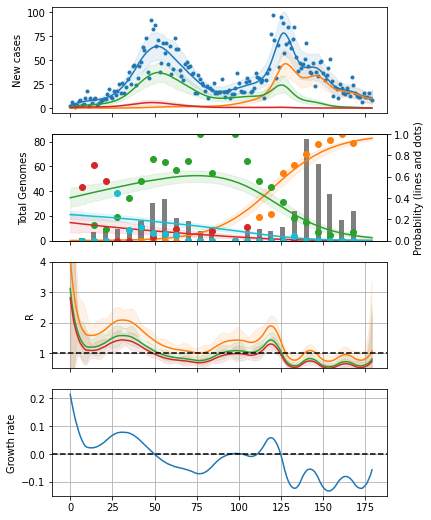

In [63]:
fig, axes = plt.subplots(4,1, figsize=(6, 9), sharex=True)
axes[0].plot(np.arange(180), cases[idx], '.')
axes[0].plot(np.arange(180), model.posterior.median('lamb', idx), 'C0')
axes[0].fill_between(np.arange(180), model.posterior.lower('lamb', idx), model.posterior.upper('lamb', idx), color='C0', alpha=.1)
axes[0].set_ylabel('New cases')


for l in lin_idx:
    axes[0].plot(np.arange(180), model.posterior.median('lamb_1', idx, Ellipsis, l), color=f'C{l+1}')
    axes[0].fill_between(np.arange(180), model.posterior.lower('lamb_1', idx, Ellipsis, l), model.posterior.upper('lamb_1', idx, Ellipsis, l), color=f'C{l+1}', alpha=.1)
   # axes[0].plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, l]/lineages_red[idx].sum(-1), f'C{l+1}o')

axes[1].bar(np.arange(180)[lineage_date_idx], lineages_red.sum(-1)[idx], color='C7', width=3)
axes[1].set_ylabel('Total Genomes')

ax2 = axes[1].twinx()

for l in lin_idx:
    ax2.plot(np.arange(180), model.posterior.median('p', idx, Ellipsis, l), color=f'C{l+1}')
    ax2.fill_between(np.arange(180), model.posterior.lower('p', idx, Ellipsis, l), model.posterior.upper('p', idx, Ellipsis, l), color=f'C{l+1}', alpha=.1)
    ax2.plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, l]/lineages_red[idx].sum(-1), f'C{l+1}o')

ax2.plot(np.arange(180), model.posterior.median('p', idx, Ellipsis, -1), color=f'C9')
ax2.fill_between(np.arange(180), model.posterior.lower('p', idx, Ellipsis, -1), model.posterior.upper('p', idx, Ellipsis, -1), color=f'C9', alpha=.1)
ax2.plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, -1]/lineages_red[idx].sum(-1), f'C9o')
ax2.set_ylim([0,1])
ax2.set_ylabel('Probability (lines and dots)')
    
for l in lin_idx:
    axes[2].plot(np.arange(180), model.posterior.median('R_1', idx, Ellipsis, l), color=f'C{l+1}')
    axes[2].fill_between(np.arange(180), model.posterior.lower('R_1', idx, Ellipsis, l), model.posterior.upper('R_1', idx, Ellipsis, l), color=f'C{l+1}', alpha=.1)
    #axes[2].plot(np.arange(180)[lineage_date_idx], lineages_red[idx, :, l]/lineages_red[idx].sum(-1), f'C{l+1}o')
    
axes[2].set_ylim([0.5, 4])
axes[2].axhline(1, linestyle='--', color='k')
axes[2].yaxis.grid(True)
axes[2].xaxis.grid(True)
axes[2].set_ylabel('R')


axes[3].plot(np.arange(180), model.posterior.median('G', idx))
axes[3].axhline(0, linestyle='--', color='k')
axes[3].set_ylabel('Growth rate')
axes[3].yaxis.grid(True)
axes[3].xaxis.grid(True)

(180,)